## Table of contents
1. [Initialization](#initialization)
2. [Basic Data Exploration,Feature Creation and Transformation](#bda)
3. [Feature Analysis](#fa)
    1. [ContractID](#contID)
    2. [Star Rating](#star)
    3. [Room Type](#room)
    4. [Arrival Month](#month)
    5. [Category](#cat)
    6. [Meal Basis](#meal)
    7. [Contract Type](#contract)
    8. [Other Date Variables](#date)
    9. [Time Variables](#time)
    10. [City](#city)
    11. [Hotel Key](#hotel)
4. [Data Set Transformation](#transformation)
5. [Outlier/Anomaly Detection](#outlierDetection)    
    1. [Statistical and Visual Approach](#stat)
    2. [Clustering and Regression Approach](#cluster)
5. [Anomaly Labeling and Submission](#submit)

In [90]:
# importing primary libraries
import numpy as np
import pandas as pd
from collections import Counter
import datetime as dt
import workdays
import glob
import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.feature_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)


%matplotlib inline


# Loading cleaned df
df = pd.read_csv('CleanData.csv', index_col= 0)
# New list that comprises all the categorical variables from the Data Frame
categoricalVariables = ['city_code','category_room','contract_type','room_type','meal_basis',
                       'creation_date_month', 'creation_date_day',
                       'creation_date_weekday', 'arrival_date_month', 'arrival_date_day',
                       'arrival_date_weekday', 'departure_date_month', 'departure_date_day',
                       'departure_date_weekday','star_rating']

# Change the variable type of the previous list to 'category'
for i in categoricalVariables:
    df[i] = df[i].astype('category')

df.head()

,hotel_hkey,contract_id_hkey,city_code,category_room,contract_type,room_type,meal_basis,star_rating,row_id,creation_date_month,creation_date_day,creation_date_weekday,arrival_date_month,arrival_date_day,arrival_date_weekday,departure_date_month,departure_date_day,departure_date_weekday,TripNoOfDays,TripWorkingDays,TripWeekends,BookingLeadTime,PricePerNight
0,-8267178856752109189,-2268968424949879745,1,ST-1,NOR,DBL,BB,4,0,5,15,1,12,27,3,1,2,2,7,5,2,226,1506
1,-1685290188623826844,-6660022717883519295,0,ST,NRF,DBT,RO,3,1,5,15,1,7,21,5,7,24,1,4,2,2,67,122
2,-7840397635682426109,-5150800997425879880,0,PP,NONE,DBL,BB,5,2,5,15,1,8,29,2,9,2,6,5,3,2,106,2702
3,-6857665811800939251,-7369482760620721804,1,ST,NOR,TWN,BB,3,3,5,15,1,5,24,3,5,27,6,4,2,2,9,1275
4,-7182313616126400607,-8424448225994711484,6,ST,OPQ,CAB,RO,4,4,5,15,1,11,24,5,11,29,3,6,4,2,193,2136


### Feature Analysis <a name="fa"></a>

#### Contract ID Key <a name="contID"></a>
##### The contract ID key represents a aggregation of properties of the booking based on the variables related to the hotel such as hotel, contract type, room type, meal basis and so on. Hence it is a good idea to create mean, median and standard deviation of the records grouped by the contract id. We can use the displacement of the price from these median values (considering the std dev and mean) as indicators of possible outliers or potential anomalies

In [84]:
# Mean 'PricePerNight' grouped by all the contracts id's
contractIdMean = df.groupby(['contract_id_hkey'])['PricePerNight'].mean()

# Function to return mean of each contract
def getContractMean(cid):
    return(contractIdMean[cid])
# New column to store the difference between the 'PricePerNight' and the newly created 'ContractIdMean'
df['ContractIdMean'] = df.contract_id_hkey.apply(getContractMean)
df['priceDifbyContractMean'] = df['PricePerNight'] - df['ContractIdMean']

#df = df.drop(['ContractIdMean'], axis = 1)

#### Star Rating <a name="star"></a>

In [ ]:
# Description of the variable
df.star_rating.describe()

We see that the hotel star rating can be converted to ordinal scale of 1 to 5. For this we compare the median prices of each non numbered category with values of the star ratings for each of the corresponding cities/star. This way we can rank the non numbered star rating categories into numbered star ratings

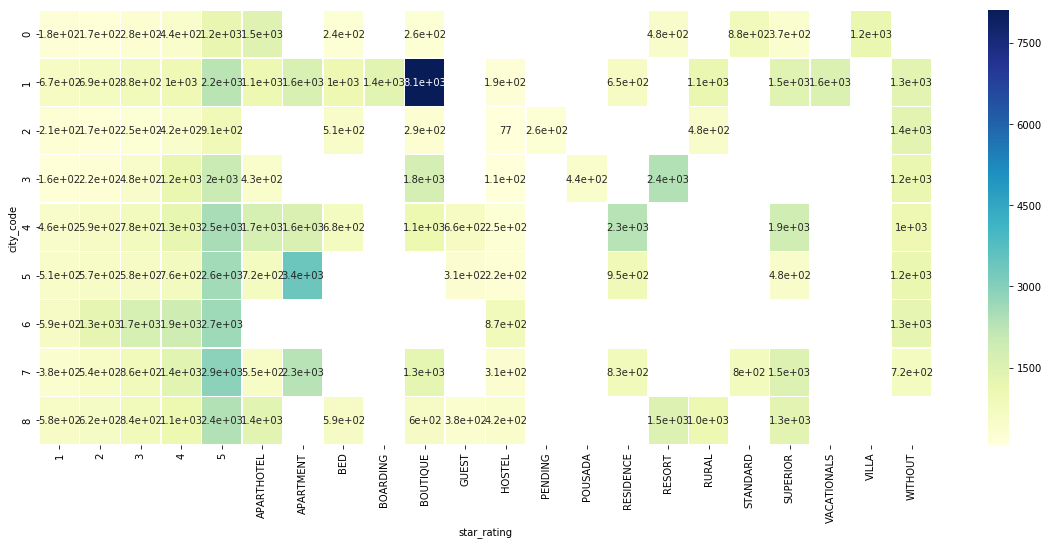

In [8]:
# Heatmap of the 'star_rating' per city against its 'PricePerNight'
plt.figure(figsize=(20,8))
sns.heatmap(df.groupby(["city_code", "star_rating"])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu", annot=True);

In [9]:
# Rules for Star Rating
Hotelratings = {
                ("APARTHOTEL",0): 5, ("APARTHOTEL",1): 4, ("APARTHOTEL",3): 3, ("APARTHOTEL",4): 4, ("APARTHOTEL",5): 4,
                ("APARTHOTEL",7): 2, ("APARTHOTEL",8): 4, ("APARTMENT",1): 4, ("APARTMENT",4): 4, ("APARTMENT",5): 5, 
                ("APARTMENT",7): 4, ("BED",0): 1, ("BED",1): 4, ("BED",2): 4, ("BED",4): 3, ("BED",8): 1, ("BOARDING",1): 4,
                ("BOUTIQUE",0): 3, ("BOUTIQUE",1): 1, ("BOUTIQUE",2): 3, ("BOUTIQUE",3): 5, ("BOUTIQUE",4): 4, 
                ("BOUTIQUE",7): 4, ("BOUTIQUE",8): 1, ("GUEST",4): 2, ("GUEST",5): 1, ("GUEST",8): 1, ("HOSTEL",1): 1,
                ("HOSTEL",2): 1, ("HOSTEL",3): 1, ("HOSTEL",4): 1, ("HOSTEL",5): 1, ("HOSTEL",6): 1, ("HOSTEL",7): 1,
                ("HOSTEL",8): 1, ("PENDING",2): 3, ("POUSADA",3): 3, ("RESIDENCE",1): 1, ("RESIDENCE",4): 5, 
                ("RESIDENCE",5): 4, ("RESIDENCE",7): 3, ("RESORT",0): 4, ("RESORT",3): 5, ("RESORT",8): 4, ("RURAL",1): 4,
                ("RURAL",2): 4, ("RURAL",8): 4, ("STANDARD",0): 4, ("STANDARD",7): 3, ("SUPERIOR",7): 4, ("SUPERIOR",8): 4,
                ("SUPERIOR",4): 4, ("SUPERIOR",0): 4, ("SUPERIOR",1): 4, ("SUPERIOR",5): 1, ("VACATIONALS",1): 4, 
                ("VILLA",0): 5, ("WITHOUT",1): 4, ("WITHOUT",2): 5, ("WITHOUT",3): 4, ("WITHOUT",4): 4, ("WITHOUT",5): 4,
                ("WITHOUT",6): 4, ("WITHOUT",7): 4
                }

In [10]:
# Function to Return the Star rating of the booked Hotel based on the above Rule
def getRating(t):
    return(Hotelratings[t])

In [12]:
# Create new variable 'combo' containing a touple with the 'star_rating' and the 'city_code'
df['combo'] = df[['star_rating', 'city_code']].apply(tuple, axis=1)

# Application of the aforementioned rules into the new feature 'HotelStarRating'
df['HotelStarRating'] = 0
df.loc[df.star_rating.isin(['5','4','3','2','1']),'HotelStarRating'] = df.star_rating
df.loc[df.HotelStarRating == 0, 'HotelStarRating'] =  df.loc[df.HotelStarRating == 0, :].combo.apply(getRating)
df.HotelStarRating = df.HotelStarRating.astype(int)

In [13]:
# Edit the variable 'star_rating'so that it returns 'HOTEL' if the instance contains a number of stars
df.star_rating = df.star_rating.astype('object')
df.loc[df.star_rating.isin(['5','4','3','2','1']),'star_rating'] = 'HOTEL'

In [14]:
df.star_rating.describe()
#df.star_rating.value_counts()

count     895809
unique        18
top        HOTEL
freq      857657
Name: star_rating, dtype: object

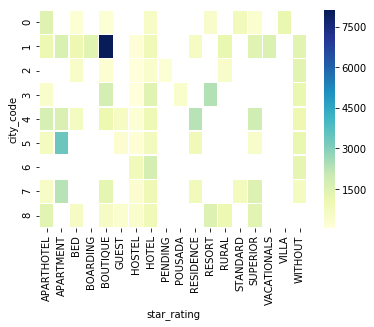

In [15]:
# Heatmap of the edited 'star_rating' variable per city against its price
sns.heatmap(df.groupby(["city_code", "star_rating"])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu");

In [16]:
# Return the median and standard deviation of the 'PricePerNight' grouped by the 'star_rating'
print(df.groupby(["star_rating"])['PricePerNight'].median().sort_values(ascending = False))
#print(df.groupby(["star_rating"])['PricePerNight'].mean().sort_values(ascending = False))
print(df.groupby(["star_rating"])['PricePerNight'].std().sort_values(ascending = False))

star_rating
APARTMENT      1655.5
VACATIONALS    1557.5
BOARDING       1379.0
SUPERIOR       1284.0
VILLA          1183.0
BOUTIQUE        992.0
APARTHOTEL      945.0
WITHOUT         921.0
RURAL           904.5
HOTEL           891.0
STANDARD        841.5
RESIDENCE       810.5
BED             758.5
RESORT          488.0
POUSADA         444.0
GUEST           372.0
PENDING         260.0
HOSTEL          236.0
Name: PricePerNight, dtype: float64
star_rating
WITHOUT        1283.438369
SUPERIOR       1219.854192
BOUTIQUE       1160.158134
HOTEL          1122.326556
RESIDENCE      1073.416778
VACATIONALS    1034.681381
APARTMENT      1005.278242
VILLA           956.904016
APARTHOTEL      830.094163
RURAL           763.609692
RESORT          568.026324
BED             555.839556
GUEST           464.527309
STANDARD        411.736393
HOSTEL          359.521418
POUSADA          63.720745
PENDING          53.702886
BOARDING               NaN
Name: PricePerNight, dtype: float64


In [17]:
# Remove the variable 'combo' as we will no longer use it
df = df.drop(['combo'], axis = 1)

The type of hotel is not revealing much information. We will thus continue with using the ordinal scale from 1 : 5 as that has greater relevance for understanding the pricing

#### Room Type <a name="room"></a>

For room type we will take a standard approach of checkinig which room types have higher prices (on an average or as per median). Using this as a metric we will convert the categories into a ranked numerical scale which can have a better correlation to the prices


In [18]:
# Describing the median of 'PricePerNight' per 'room_type' and count of the records in each type of room
print(df.groupby(["room_type"])['PricePerNight'].median().sort_values(ascending = False))
Counter(df['room_type']).most_common(26)

room_type
TWH    2481.0
DLX    2020.0
JSU    2002.0
CHA    1813.5
LOD    1467.0
CAB    1403.0
VIL    1385.0
FAM    1342.0
SUI    1306.0
CTG    1235.0
TPL    1230.0
APT    1201.0
ROO    1191.0
QUA    1127.0
DBL    1027.0
TLN     935.0
BUN     915.5
TWN     780.0
STU     771.0
DUS     709.0
SGL     693.0
HOM     686.0
DBT     628.0
BED     168.0
Name: PricePerNight, dtype: float64


[('DBL', 344606),
 ('DBT', 199928),
 ('TWN', 66600),
 ('SGL', 55616),
 ('DUS', 33656),
 ('TPL', 33514),
 ('APT', 30985),
 ('ROO', 24785),
 ('STU', 22567),
 ('SUI', 21310),
 ('QUA', 14940),
 ('FAM', 14255),
 ('JSU', 12295),
 ('VIL', 10779),
 ('BED', 8194),
 ('CAB', 1151),
 ('BUN', 424),
 ('LOD', 86),
 ('TWH', 45),
 ('CTG', 40),
 ('CHA', 16),
 ('TLN', 15),
 ('DLX', 1),
 ('HOM', 1)]

In [19]:
# Creation of a new Data Frame containing the median of the 'PricePerNight' per 'room_type'
medianPriceByRoomType = df.groupby(["room_type"])['PricePerNight'].median().sort_values(ascending = False)

In [20]:
# Add this feature into the main Data Frame
df['MedianPriceByRoomType'] = 0
for i in medianPriceByRoomType.index:
    df.loc[df.room_type == i,'MedianPriceByRoomType'] = medianPriceByRoomType[i]


In [21]:
medianPriceByRoomType

room_type
TWH    2481.0
DLX    2020.0
JSU    2002.0
CHA    1813.5
LOD    1467.0
CAB    1403.0
VIL    1385.0
FAM    1342.0
SUI    1306.0
CTG    1235.0
TPL    1230.0
APT    1201.0
ROO    1191.0
QUA    1127.0
DBL    1027.0
TLN     935.0
BUN     915.5
TWN     780.0
STU     771.0
DUS     709.0
SGL     693.0
HOM     686.0
DBT     628.0
BED     168.0
Name: PricePerNight, dtype: float64

#### Arrival Month <a name="month"></a>
Based on our understanding of tourism industry we have an hypothesis that PricePerNight tends to be higher in summer break months and december. We will go ahead and explore the distribution of prices by arrival month and verify this

HotelStarRating         1       2      3       4       5
arrival_date_month                                      
1                   188.0   354.0  484.0   652.0  1453.0
2                   216.5   385.0  524.0   722.0  1478.0
3                   297.5   471.0  618.0   806.0  1543.0
4                   293.0   517.0  659.0   896.0  1511.5
5                   330.0   571.0  703.0   969.0  1534.0
6                   381.0   681.0  793.0  1060.0  1571.0
7                   495.0   872.0  956.0  1315.0  1864.0
8                   599.0   940.0  937.0  1329.0  1736.0
9                   447.5   764.0  957.0  1323.5  1596.0
10                  373.0   697.5  896.0  1268.0  1578.0
11                  388.0   624.5  733.0  1298.0  1653.0
12                  346.0  1299.0  838.0  1587.0  2228.0


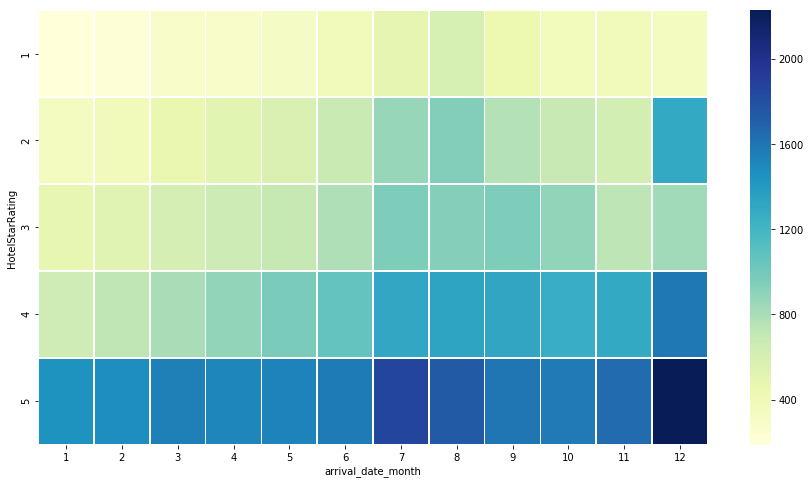

In [22]:
# matrix of the 'PricePerNight' by 'HotelStarRating' and 'arrival_date_month'
print(df.groupby(["arrival_date_month", "HotelStarRating"])['PricePerNight'].median().unstack())

# Heatmap of the edited 'arrival_date_month' variable per 'HotelStarRating' against its price
plt.figure(figsize=(15,8))
sns.heatmap(df.groupby(["HotelStarRating","arrival_date_month"])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu");

Based on the heatmap we confirm that the previous statement is true, and now a new varible will be created to group months with similar prices and a rank will be assigned based on price.

In [23]:
# New feature 'monthRating' that group months with similar prices
df['monthRating'] = 0
df.loc[df.arrival_date_month.isin(['1','2']), 'monthRating'] = 1
df.loc[df.arrival_date_month.isin(['3','4','5']), 'monthRating'] = 5
#df.loc[df.arrival_date_month.isin(['11','12']), 'monthRating'] = 4
df.loc[df.arrival_date_month.isin(['6','9','10','11']), 'monthRating'] = 25
df.loc[df.arrival_date_month.isin(['7','8','12']), 'monthRating'] = 75

#### Category Room <a name="cat"></a>
A similar ranking apporoach will be used for category of the room as well. Since it has > 1000 category levels, not much information can be extracted apart from converting it to an ordinal scale of values

In [27]:
# Count the number instances in each factor
Counter(df['category_room']).most_common(1319)

[('ST', 409504),
 ('DX', 71145),
 ('SU', 31541),
 ('SU-1', 30255),
 ('AS', 22833),
 ('XX-SU', 22545),
 ('SP', 18194),
 ('QN', 11384),
 ('ST-1', 9679),
 ('KG', 8336),
 ('C2', 7593),
 ('OM', 7481),
 ('VM', 7174),
 ('EJ', 6738),
 ('GD', 6608),
 ('PE', 5695),
 ('EY', 5088),
 ('PI', 4777),
 ('XX-2B', 4769),
 ('OV', 4513),
 ('DX-1', 4450),
 ('XX-1B', 4113),
 ('B1', 4077),
 ('DX-KG', 4047),
 ('LX', 3722),
 ('B2', 3544),
 ('NM', 3529),
 ('1B-1', 3433),
 ('DB', 3060),
 ('C3', 3018),
 ('Z1', 3006),
 ('1B', 2885),
 ('PR', 2694),
 ('2D', 2676),
 ('B1-C4', 2603),
 ('XX-GR', 2562),
 ('IN', 2561),
 ('BL', 2522),
 ('C4', 2473),
 ('ST-2', 2350),
 ('GR', 2333),
 ('B1-1', 2084),
 ('DX-GV', 2059),
 ('C1', 2043),
 ('1E', 2038),
 ('SU-4', 1664),
 ('AS-DB', 1653),
 ('2B-1', 1650),
 ('DX-GD', 1644),
 ('RO', 1636),
 ('ST-3', 1597),
 ('QN-SU', 1540),
 ('SU-2', 1492),
 ('VL', 1439),
 ('2D-AS', 1423),
 ('C8', 1419),
 ('XX-B1', 1396),
 ('KG-NM', 1371),
 ('SS', 1321),
 ('KG-SU', 1314),
 ('GV', 1271),
 ('DX-EJ', 125

In [28]:
# Count the number instances in each factor
Counter(df['category_room']).most_common(1319)

[('ST', 409504),
 ('DX', 71145),
 ('SU', 31541),
 ('SU-1', 30255),
 ('AS', 22833),
 ('XX-SU', 22545),
 ('SP', 18194),
 ('QN', 11384),
 ('ST-1', 9679),
 ('KG', 8336),
 ('C2', 7593),
 ('OM', 7481),
 ('VM', 7174),
 ('EJ', 6738),
 ('GD', 6608),
 ('PE', 5695),
 ('EY', 5088),
 ('PI', 4777),
 ('XX-2B', 4769),
 ('OV', 4513),
 ('DX-1', 4450),
 ('XX-1B', 4113),
 ('B1', 4077),
 ('DX-KG', 4047),
 ('LX', 3722),
 ('B2', 3544),
 ('NM', 3529),
 ('1B-1', 3433),
 ('DB', 3060),
 ('C3', 3018),
 ('Z1', 3006),
 ('1B', 2885),
 ('PR', 2694),
 ('2D', 2676),
 ('B1-C4', 2603),
 ('XX-GR', 2562),
 ('IN', 2561),
 ('BL', 2522),
 ('C4', 2473),
 ('ST-2', 2350),
 ('GR', 2333),
 ('B1-1', 2084),
 ('DX-GV', 2059),
 ('C1', 2043),
 ('1E', 2038),
 ('SU-4', 1664),
 ('AS-DB', 1653),
 ('2B-1', 1650),
 ('DX-GD', 1644),
 ('RO', 1636),
 ('ST-3', 1597),
 ('QN-SU', 1540),
 ('SU-2', 1492),
 ('VL', 1439),
 ('2D-AS', 1423),
 ('C8', 1419),
 ('XX-B1', 1396),
 ('KG-NM', 1371),
 ('SS', 1321),
 ('KG-SU', 1314),
 ('GV', 1271),
 ('DX-EJ', 125

In [30]:
# New Data Frame containing the median 'PricePerNight' be 'category_room'
categoryRoomPriceRank = df.groupby(["category_room"])['PricePerNight'].median().sort_values(ascending = False)
# Creating rank for records based on 'room_category'
categoryRoomPriceRank = categoryRoomPriceRank.fillna(0)
maxi = max(categoryRoomPriceRank)
categoryRoomPriceRank = (categoryRoomPriceRank/maxi) * 100
categoryRoomPriceRank = categoryRoomPriceRank.astype(int)

In [31]:
# Adding this feature to the main Data Frame
df['categoryRoomPriceRank'] = 0
for i in categoryRoomPriceRank.index:
    df.loc[df.category_room == i,'categoryRoomPriceRank'] = categoryRoomPriceRank[i]

In [32]:
df.star_rating.describe()

count     895809
unique        18
top        HOTEL
freq      857657
Name: star_rating, dtype: object

#### Meal Basis <a name="meal"></a>
Meal basis will obviously have an influence on the price of the bookings. We can explore which meal categories are higher priced in general. Using this information we can create a score to force a postive correlation between meal basis and price per night

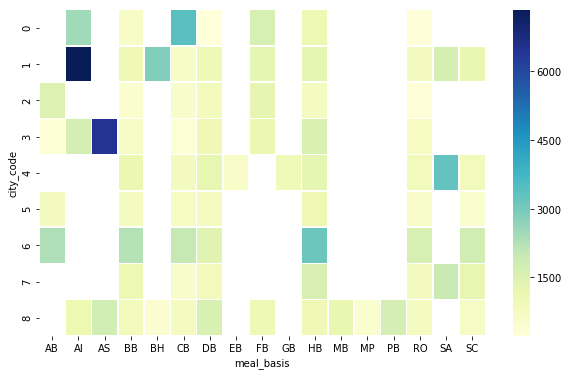

In [33]:
plt.figure(figsize=(10,6))
sns.heatmap(df.groupby(["city_code","meal_basis"])['PricePerNight'].median().sort_values(ascending= False).unstack()
            ,linewidths=.5, cmap="YlGnBu");

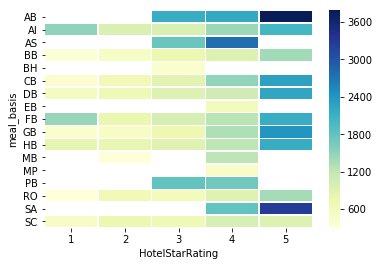

In [34]:
sns.heatmap(df.groupby(["meal_basis", "HotelStarRating"])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu");

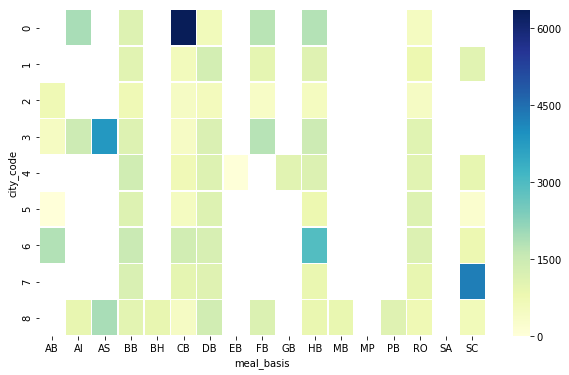

In [35]:
plt.figure(figsize=(10,6))
sns.heatmap(df.groupby(["city_code","meal_basis"])['PricePerNight'].std().sort_values(ascending= False).unstack()
            ,linewidths=.5, cmap="YlGnBu");

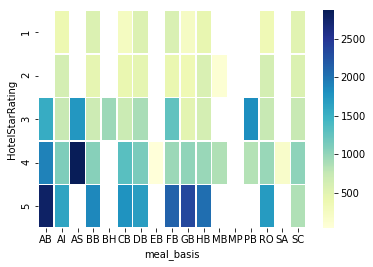

In [36]:
sns.heatmap(df.groupby([ "HotelStarRating","meal_basis"])['PricePerNight'].std().unstack()
            ,linewidths=.5, cmap="YlGnBu");

In [38]:
# New feature for scoring based on the deviation of price from median grouped by 'mealBasis'
df['mealBasisDeviation'] = 1
df.loc[df.meal_basis.isin(['CB','FB','DB']),'mealBasisDeviation'] = 5
df.loc[df.meal_basis.isin(['HB','SC']),'mealBasisDeviation'] = 2

df.groupby(["meal_basis"])['PricePerNight'].median().sort_values(ascending = False)

df.groupby(["meal_basis"])['PricePerNight'].count().sort_values(ascending = False)

meal_basis
AB    2218
SA    1929
AS    1844
PB    1702
AI    1503
MB    1171
FB    1151
HB    1078
DB    1064
GB     995
CB     873
BB     870
RO     774
SC     741
EB     607
MP     478
BH     434
Name: PricePerNight, dtype: int64

meal_basis
BB    418592
RO    320241
AI     57327
CB     24141
HB     23101
GB     20704
SC     17914
DB     10510
AB      1742
FB      1128
MB       231
AS       111
PB        30
BH        27
EB         6
SA         3
MP         1
Name: PricePerNight, dtype: int64

In [39]:
# Create rank variable for 'meal_basis'
mealBasisRank = df.groupby(["meal_basis"])['PricePerNight'].median().sort_values(ascending = False)
mealBasisRank = mealBasisRank.fillna(0)
maxi = max(mealBasisRank)
mealBasisRank = (mealBasisRank/maxi) * 100
mealBasisRank = mealBasisRank.astype(int)
mealBasisRank

meal_basis
AB    100
SA     86
AS     83
PB     76
AI     67
MB     52
FB     51
HB     48
DB     47
GB     44
CB     39
BB     39
RO     34
SC     33
EB     27
MP     21
BH     19
Name: PricePerNight, dtype: int64

In [40]:
# Adding this variable to the main Data Frame
df['mealBasisRank'] = 0
for i in mealBasisRank.index:
    df.loc[df.meal_basis == i,'mealBasisRank'] = mealBasisRank[i]

#### Contract Type <a name="contract"></a>
ContractID is already storing information of contract details of each booking. However we will dummify and re-group the contract type variable to reduce the number of levels

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


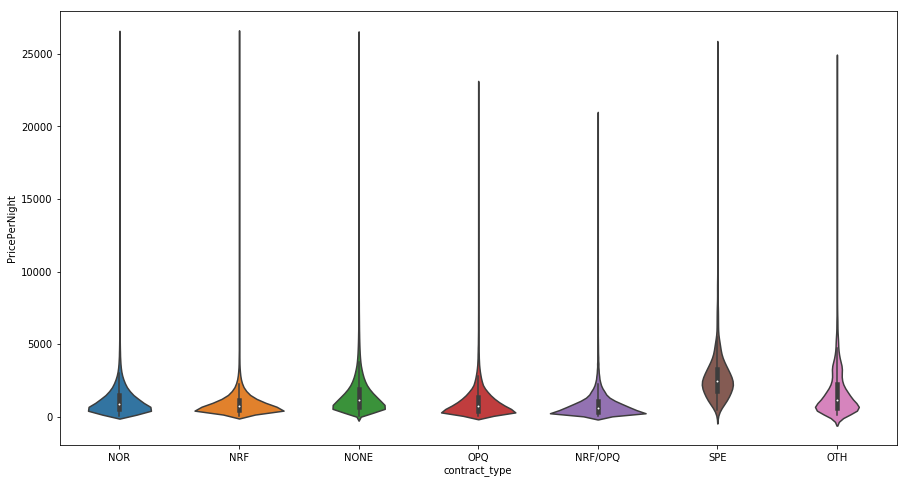

In [41]:
# Violin plot describing the distribution of price per type of contract
plt.figure(figsize=(15,8))
sns.violinplot(x='contract_type', y='PricePerNight', data=df);

**NOR** - Normal

**NRF** - Non-Refundable

**NONE** - No Contract

**OPQ** - Opaque (Selling unsold travel inventory at a discounted price)

**NRF/OPQ** - Non-Refundable and Opaque

**SPE** - Special

**OTH** - Other

In [42]:
df.groupby(["contract_type", "HotelStarRating"])['PricePerNight'].median().unstack()

HotelStarRating,1,2,3,4,5
contract_type,,,,,
NONE,438.5,900.0,893.0,1271.0,2159.0
NOR,402.0,659.0,766.0,1032.0,1539.0
NRF,295.0,471.0,677.0,859.0,1096.0
NRF/OPQ,180.0,398.0,346.0,739.0,1076.0
OPQ,170.0,513.0,636.0,778.0,1755.0
OTH,NaN,1196.5,865.0,657.0,1614.0
SPE,NaN,NaN,NaN,833.0,2495.5


In [43]:
df.groupby(["contract_type"])['PricePerNight'].std().sort_values(ascending = False)

contract_type
SPE        1917.194706
OTH        1676.728725
NONE       1518.284895
NOR        1077.064501
OPQ        1053.783327
NRF/OPQ     829.259629
NRF         779.939128
Name: PricePerNight, dtype: float64

In [44]:
df.groupby(["contract_type"])['PricePerNight'].count().sort_values(ascending = False)

contract_type
NOR        497528
NRF        129500
OPQ        124176
NONE       113724
NRF/OPQ     27242
OTH          2566
SPE          1073
Name: PricePerNight, dtype: int64

In [45]:
df.groupby(["contract_type"])['PricePerNight'].max().sort_values(ascending = False)

contract_type
NRF        26469
NOR        26422
NONE       26245
SPE        24930
OTH        24247
OPQ        22929
NRF/OPQ    20782
Name: PricePerNight, dtype: int64

In [46]:
# Regrouping and dummifying the contract type
df['contract_NOR'] = 0
df.loc[df.contract_type == 'NOR', 'contract_NOR'] = 1

df['contract_OPQ'] = 0
df.loc[(df.contract_type == 'OPQ')  | (df.contract_type == 'NRF/OPQ') , 'contract_OPQ'] = 1

df['contract_NRF'] = 0
df.loc[(df.contract_type == 'NRF')  | (df.contract_type == 'NRF/OPQ') , 'contract_NRF'] = 1

df['contract_UND'] = 0
df.loc[(df.contract_type == 'OTH')  | (df.contract_type == 'NONE') , 'contract_UND'] = 1

df['contract_SPE'] = 0
df.loc[(df.contract_type == 'SPE'), 'contract_SPE'] = 1

In [47]:
# New feature for storing the contract deviation
df['contractDeviation'] = 1
df.loc[df.contract_type.isin(['OTH','NONE','SPE']),'contractDeviation'] = 5

#### Other Date Variables <a name="date"></a>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

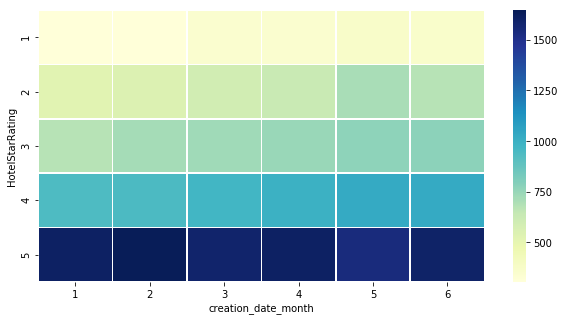

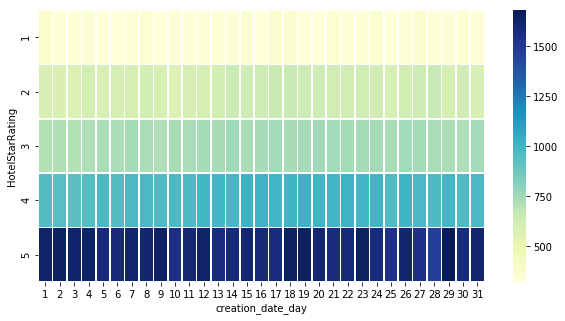

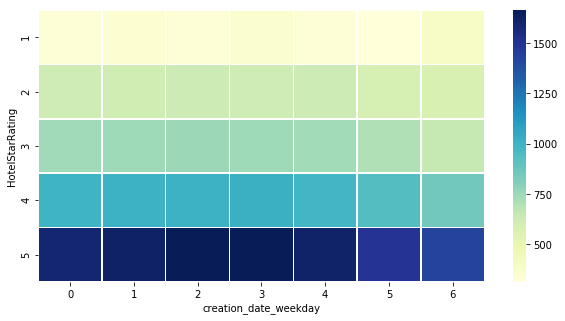

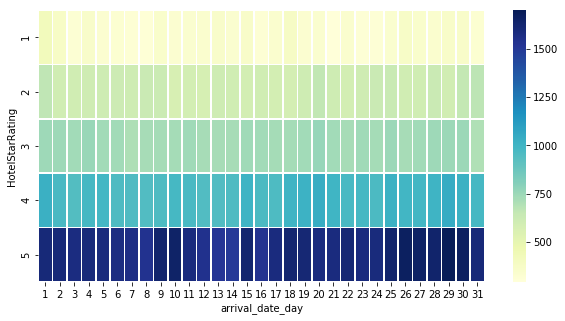

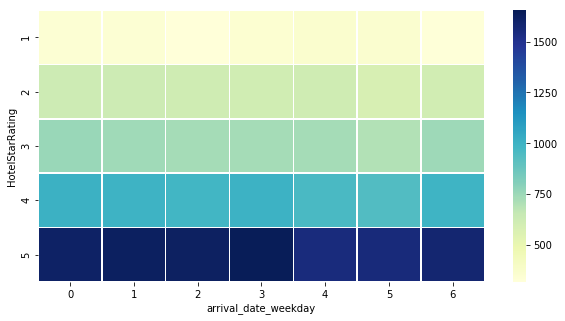

In [49]:
dateVar = ['creation_date_month', 'creation_date_day', 'creation_date_weekday',
           'arrival_date_day', 'arrival_date_weekday']

for i, var in enumerate(dateVar):
    plt.figure(i,figsize=(10,5))
    sns.heatmap(df.groupby(["HotelStarRating",var])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu")

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

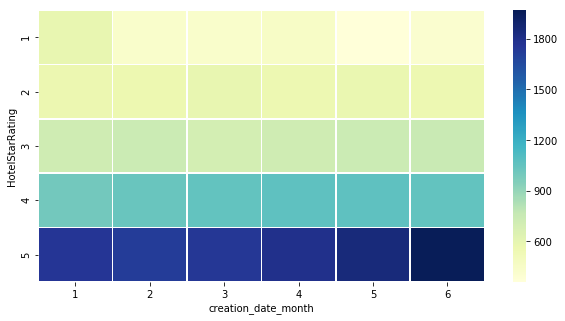

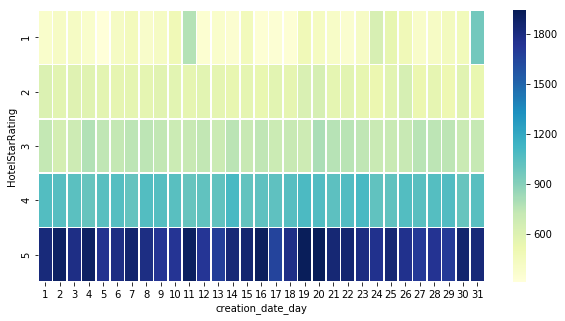

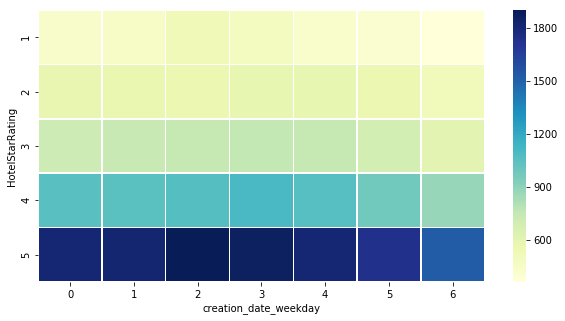

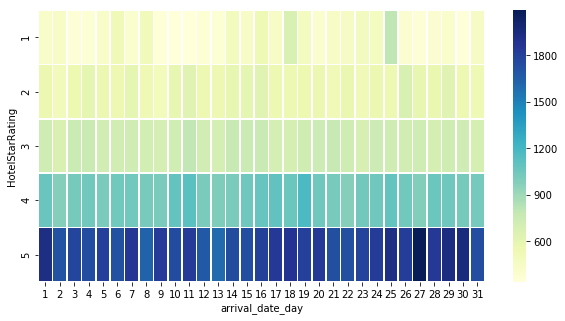

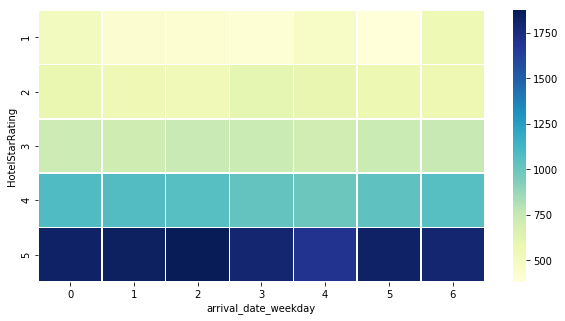

In [50]:
for i, var in enumerate(dateVar):
    plt.figure(i,figsize=(10,5))
    sns.heatmap(df.groupby(["HotelStarRating",var])['PricePerNight'].std().unstack()
            ,linewidths=.5, cmap="YlGnBu")

Apart from month (analysed before) date Variables are not adding much value is not adding any additional Value to understand the median prices

#### Time Variables <a name="time"></a>

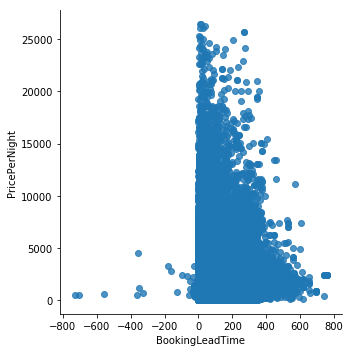

In [51]:
# Scatter plot of price by 'BookingLeadTime'
sns.lmplot(x= 'BookingLeadTime', # Horizontal axis
           y= 'PricePerNight',   # Vertical axis
           data=df,              # Data source
           fit_reg=False,        # Don't fix a regression line
           );

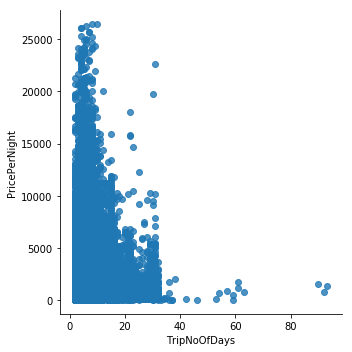

In [52]:
# By Trip Days
sns.lmplot(x= 'TripNoOfDays',  # Horizontal axis
           y= 'PricePerNight', # Vertical axis
           data=df,            # Data source
           fit_reg=False,      # Don't fix a regression line
           );

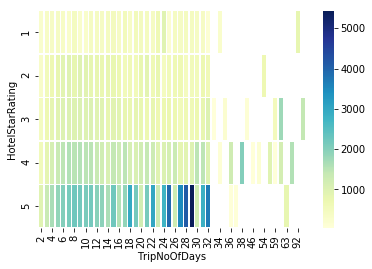

In [53]:
sns.heatmap(df.groupby(["HotelStarRating",'TripNoOfDays'])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu");

In [54]:
# Binning the higher values of the variables 'TripNoOfDays'
df.loc[df.TripNoOfDays.isin(range(15,20)), 'TripNoOfDays'] = 15
df.loc[df.TripNoOfDays.isin(range(20,31)), 'TripNoOfDays'] = 25
df.loc[df.TripNoOfDays.isin(range(31,45)), 'TripNoOfDays'] = 40
df.loc[df.TripNoOfDays.isin(range(45,60)), 'TripNoOfDays'] = 50
df.loc[df.TripNoOfDays.isin(range(60,90)), 'TripNoOfDays'] = 80
df.loc[df.TripNoOfDays >= 90 , 'TripNoOfDays'] = 100

df.groupby(['TripNoOfDays'])['PricePerNight'].count()

TripNoOfDays
2      227007
3      166470
4      171447
5      120649
6       65153
7       35309
8       58475
9       11761
10       9565
11      11252
12       3796
13       2471
14       2392
15       7754
25       1962
40        334
50          6
80          3
100         3
Name: PricePerNight, dtype: int64

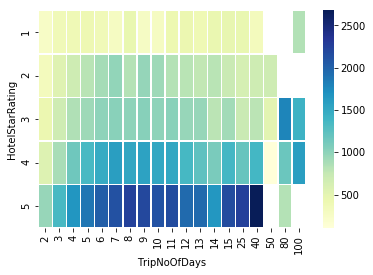

In [55]:
sns.heatmap(df.groupby(["HotelStarRating",'TripNoOfDays'])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu");

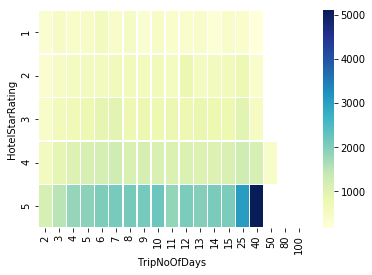

In [56]:
sns.heatmap(df.groupby(["HotelStarRating",'TripNoOfDays'])['PricePerNight'].std().unstack()
            ,linewidths=.5, cmap="YlGnBu");

We can clearly see that time of the trip has an influence on the per night price. Specially the extreme high duration trips. Thus it would be good to bin the higher values of trip duration. Also provide added information on top of the trip duration by creating new variables that store a score based on the trip duration. The standard deviation reveals information on the propensity of a trip to have anomalous pricing. Thus we create new feature to score this propoensity as well.

In [57]:
# New feature for deviation of price by duration 
df['DurationDeviation'] = 1
df.loc[df.TripNoOfDays.isin(range(7,15)),'DurationDeviation'] = 5
df.loc[df.TripNoOfDays.isin(range(15,50)),'DurationDeviation'] = 25
df.loc[df.TripNoOfDays > 50 ,'DurationDeviation'] = 125

In [58]:
# Ranking trip duration
df['durationType'] = 1
df.loc[df.TripNoOfDays.isin(range(7,12)), 'durationType'] = 20
df.loc[df.TripNoOfDays.isin(range(12,50)), 'durationType'] = 5
df.loc[df.TripNoOfDays > 50, 'durationType'] = 10

In [59]:
df.groupby(['TripWeekends'])['PricePerNight'].count()

TripWeekends
0     268631
1     187861
2     385078
3      29463
4      19314
5       2538
6       1710
7        271
8        602
9        208
10       118
11         1
12         3
14         1
15         1
16         2
18         4
25         1
26         2
Name: PricePerNight, dtype: int64

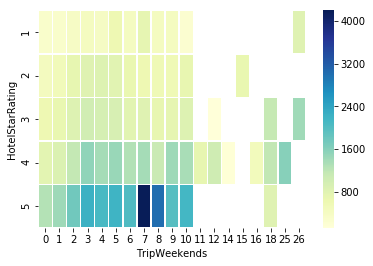

In [60]:
sns.heatmap(df.groupby(["HotelStarRating",'TripWeekends'])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu");

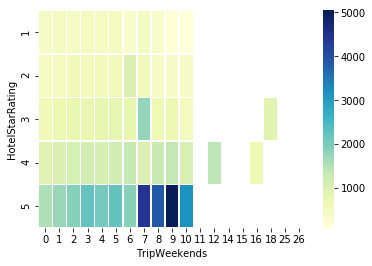

In [61]:
sns.heatmap(df.groupby(["HotelStarRating",'TripWeekends'])['PricePerNight'].std().unstack()
            ,linewidths=.5, cmap="YlGnBu");

Similar approach can be taken for the trip duration as well

In [62]:
# Treating trip weekends just like trip duration
df.loc[df.TripWeekends.isin(range(5,11)), 'TripWeekends'] = 5
df.loc[df.TripWeekends >= 11 , 'TripWeekends'] = 11

In [63]:
df['WeekendIncluded'] = 0
df.loc[(df.TripWeekends > 0), 'WeekendIncluded' ] = 1

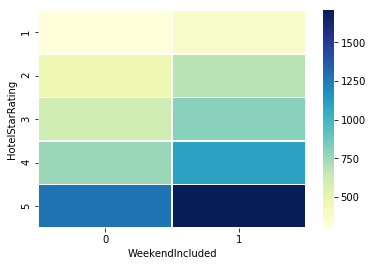

In [64]:
sns.heatmap(df.groupby(["HotelStarRating",'WeekendIncluded'])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu");

#### City <a name="city"></a>

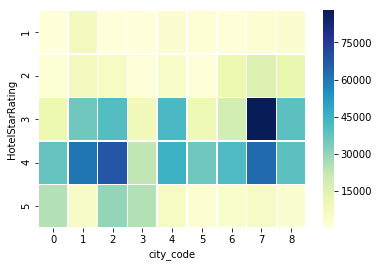

In [65]:
sns.heatmap(df.groupby(['HotelStarRating',"city_code"])['PricePerNight'].count().unstack()
            ,linewidths=.5, cmap="YlGnBu");

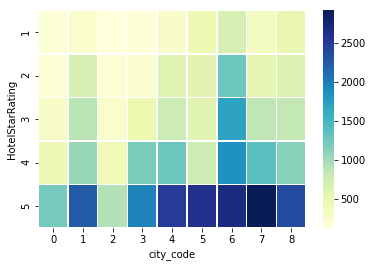

In [66]:
sns.heatmap(df.groupby(['HotelStarRating',"city_code"])['PricePerNight'].median().unstack()
            ,linewidths=.5, cmap="YlGnBu");

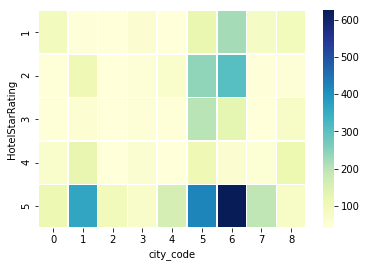

In [67]:
sns.heatmap(df.groupby(['HotelStarRating',"city_code"])['PricePerNight'].min().unstack()
            ,linewidths=.5, cmap="YlGnBu");

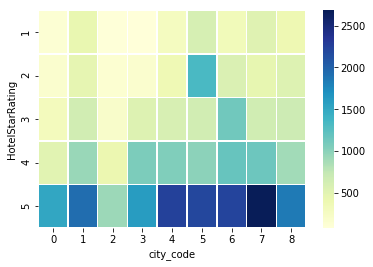

In [68]:
sns.heatmap(df.groupby(['HotelStarRating',"city_code"])['PricePerNight'].std().unstack()
            ,linewidths=.5, cmap="YlGnBu");

From the heat map we can clearly identfy cities that have relatively higher prices. We can hence group the cities and rank them based on the 'cost of living' that can be deduced from the exploration

In [77]:
# Rank the cities based on median prices
df['cityRank'] = 1
df.loc[df.city_code.isin([5,6]), 'cityRank'] = 9
df.loc[df.city_code.isin([1,4,7,8]), 'cityRank'] = 3

df['cityDeviation'] = 1
df.loc[df.city_code.isin([8,5,1]), 'cityDeviation'] = 9
df.loc[df.city_code.isin([7,6,1]), 'cityDeviation'] = 3

<Figure size 432x288 with 0 Axes>

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'0')

<Figure size 432x288 with 0 Axes>

Text(0.5,0,'1')

<Figure size 432x288 with 0 Axes>

Text(0.5,0,'2')

<Figure size 432x288 with 0 Axes>

Text(0.5,0,'3')

<Figure size 432x288 with 0 Axes>

Text(0.5,0,'4')

<Figure size 432x288 with 0 Axes>

Text(0.5,0,'5')

<Figure size 432x288 with 0 Axes>

Text(0.5,0,'6')

<Figure size 432x288 with 0 Axes>

Text(0.5,0,'7')

<Figure size 432x288 with 0 Axes>

Text(0.5,0,'8')

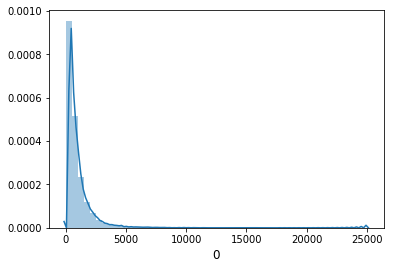

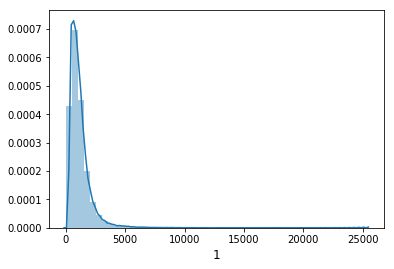

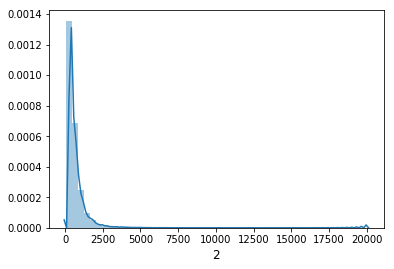

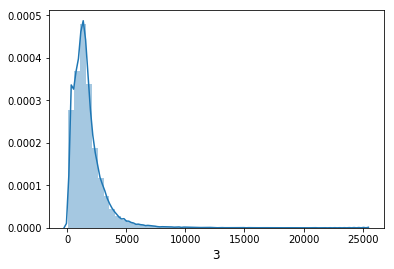

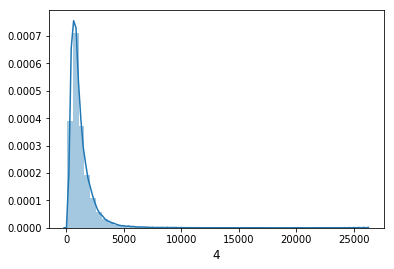

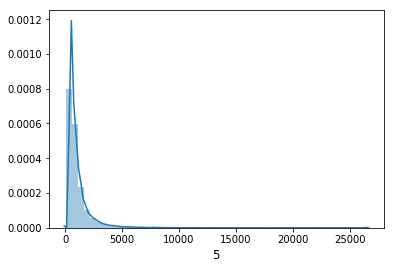

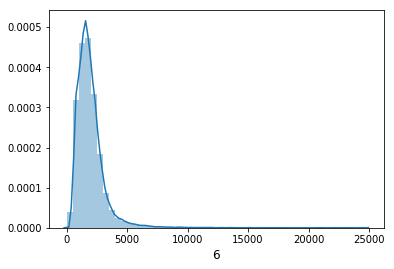

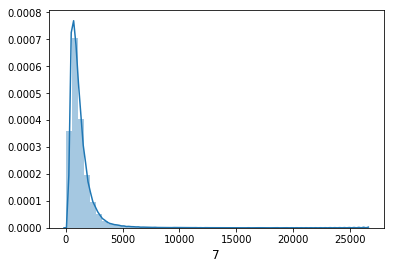

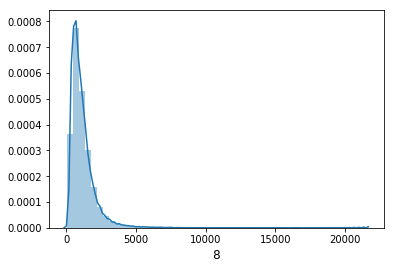

In [78]:
# Plotting the distribution of the price per city
for i, city in enumerate(df.city_code.cat.categories):
    plt.figure(i)
    #sns.distplot(train_data.loc[:,col], bins= 2)
    sns.distplot(df.loc[(df.city_code == city),'PricePerNight'])
    plt.xlabel(city, fontsize=12)

In [79]:
# New variable that takes into account the kurtosis for the previously plotted distributions
df['CityKurtosis'] = 0
for i, city in enumerate(df.city_code.cat.categories):
    df.loc[(df.city_code == city),'CityKurtosis'] = df.loc[(df.city_code == city),'PricePerNight'].kurtosis()

In [75]:
df.CityKurtosis = df.CityKurtosis.astype('int')

#### Hotel Key <a name="hotel"></a>
Though it makes sense to treat it just like contract, the information is already captured in the contractID and other hotel features. Thus it will not add any additional values

### Preparation and Transformation of Data Set <a name="transformation"></a>

In [82]:
df = df.set_index('row_id')
df.columns
df.dtypes

Index(['hotel_hkey', 'contract_id_hkey', 'city_code', 'category_room',
       'contract_type', 'room_type', 'meal_basis', 'star_rating',
       'creation_date_month', 'creation_date_day', 'creation_date_weekday',
       'arrival_date_month', 'arrival_date_day', 'arrival_date_weekday',
       'departure_date_month', 'departure_date_day', 'departure_date_weekday',
       'TripNoOfDays', 'TripWorkingDays', 'TripWeekends', 'BookingLeadTime',
       'PricePerNight', 'priceDifbyContractMean', 'HotelStarRating',
       'MedianPriceByRoomType', 'monthRating', 'categoryRoomPriceRank',
       'mealBasisDeviation', 'mealBasisRank', 'contract_NOR', 'contract_OPQ',
       'contract_NRF', 'contract_UND', 'contract_SPE', 'contractDeviation',
       'DurationDeviation', 'durationType', 'WeekendIncluded', 'cityRank',
       'cityDeviation', 'CityKurtosis'],
      dtype='object')

hotel_hkey                   int64
contract_id_hkey             int64
city_code                 category
category_room             category
contract_type             category
room_type                 category
meal_basis                category
star_rating               category
creation_date_month       category
creation_date_day         category
creation_date_weekday     category
arrival_date_month        category
arrival_date_day          category
arrival_date_weekday      category
departure_date_month      category
departure_date_day        category
departure_date_weekday    category
TripNoOfDays                 int64
TripWorkingDays              int64
TripWeekends                 int64
BookingLeadTime              int64
PricePerNight                int64
priceDifbyContractMean       int64
HotelStarRating              int64
MedianPriceByRoomType      float64
monthRating                  int64
categoryRoomPriceRank        int64
mealBasisDeviation           int64
mealBasisRank       

In [86]:
df.MedianPriceByRoomType = df.MedianPriceByRoomType.astype('int')
df.ContractIdMean = df.ContractIdMean.astype('int')
df.priceDifbyContractMean = df.priceDifbyContractMean.astype('int')

In [87]:
df.shape

(895809, 42)

In [88]:
# Dropping variables that are no longer needed
df = df.drop(['hotel_hkey', 'contract_id_hkey', 'city_code', 'category_room',
       'contract_type', 'room_type', 'meal_basis', 'star_rating',
       'creation_date_month', 'creation_date_day', 'creation_date_weekday',
       'arrival_date_month', 'arrival_date_day', 'arrival_date_weekday',
       'departure_date_month', 'departure_date_day', 'departure_date_weekday',
       ],axis =1)

In [91]:
# Saving the transformed dataset before diving into outlier detection
df.to_csv('TransformedData.csv', sep=',', header=True)